In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
import prophet
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
full = pd.read_csv('full2011-2020_features.csv')

In [3]:
full.dropna(inplace=True)

In [4]:
features = [\
          'Temperature',\
#           'Dew Point', \
          'year', \
#           'Humidity', \
#           'Pressure', \
#          'Wind Speed', \
#           'precipitation',\
          'dow',\
          'doy', \
#           'month',\
#           'hour',\
         'minute',\
#           't_m24', \
#           't_m48', \
#           'tdif'\
            
         ]
X = full[features]
y = full['load']

In [5]:
X

,Temperature,year,dow,doy,minute
0,40,2011,5,1,0
1,40,2011,5,1,5
2,40,2011,5,1,10
3,40,2011,5,1,13
4,40,2011,5,1,14
...,...,...,...,...,...
1378143,47,2023,6,365,1415
1378144,47,2023,6,365,1420
1378145,47,2023,6,365,1425
1378146,47,2023,6,365,1430


In [6]:
full['timestamp'] = full.timestamp.apply(lambda x: pd.to_datetime(x))
full = full[full.timestamp <= pd.to_datetime('2020-12-31')]

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train = full[full.timestamp < pd.to_datetime('2020')][features]
X_test = full[full.timestamp >= pd.to_datetime('2020')][features]

y_train = full[full.timestamp < pd.to_datetime('2020')]['load']
y_test = full[full.timestamp >= pd.to_datetime('2020')]['load']

In [8]:
# gbr = GradientBoostingRegressor(loss='ls', verbose=1, warm_start=True)
gbr = GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=5, verbose=1, warm_start=True)

In [9]:
gbr_fitted = gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       52262.5902            1.27m
         2       45281.8466            1.23m
         3       39656.3830            1.26m
         4       34867.1883            1.23m
         5       31001.8933            1.22m
         6       27541.0014            1.20m
         7       24727.1969            1.19m
         8       22450.1332            1.19m
         9       20333.6114            1.17m
        10       18600.2755            1.15m
        20       10235.2889            1.05m
        30        7497.8438           54.19s
        40        6282.1840           46.24s
        50        5640.2720           38.46s
        60        5227.8682           31.10s
        70        4954.8348           23.79s
        80        4730.0975           15.88s
        90        4527.5802            8.01s
       100        4398.1109            0.00s


In [10]:
gbr.score(X_train, y_train)

0.9275254489039759

In [11]:
gbr.score(X_test, y_test)

0.844402744802351

In [12]:
with open('GBR model.pkl','wb') as f:
    pickle.dump(gbr_fitted,f)

In [13]:
with open('GBR model.pkl', 'rb') as f:
    gbr_fitted = pickle.load(f)

[Text(0, 0, 'Temperature'),
 Text(0, 1, 'year'),
 Text(0, 2, 'dow'),
 Text(0, 3, 'doy'),
 Text(0, 4, 'minute')]

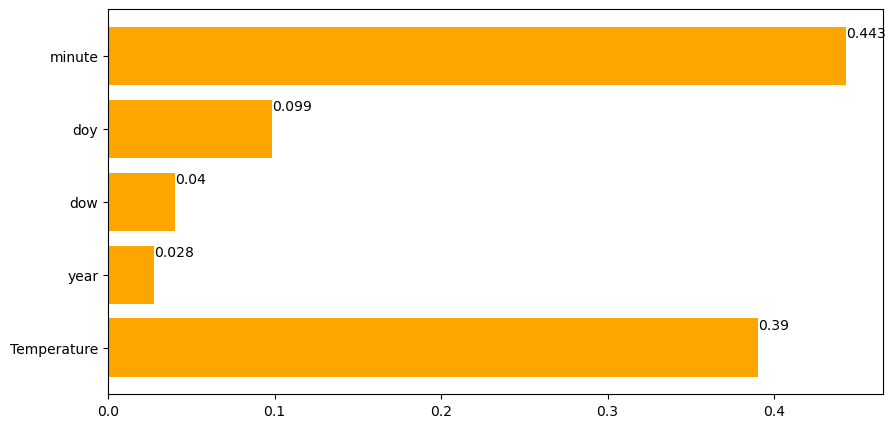

In [46]:
fi = list(gbr.feature_importances_)

fig, ax = plt.subplots(figsize=(10,5),)
ax.barh(np.arange(len(fi)), fi, color = 'orange')
for i, v in enumerate(fi):
    ax.text(v, i + .25, str(round(v, 3)))
ax.set_yticks(np.arange(len(fi)))
ax.set_yticklabels(features)

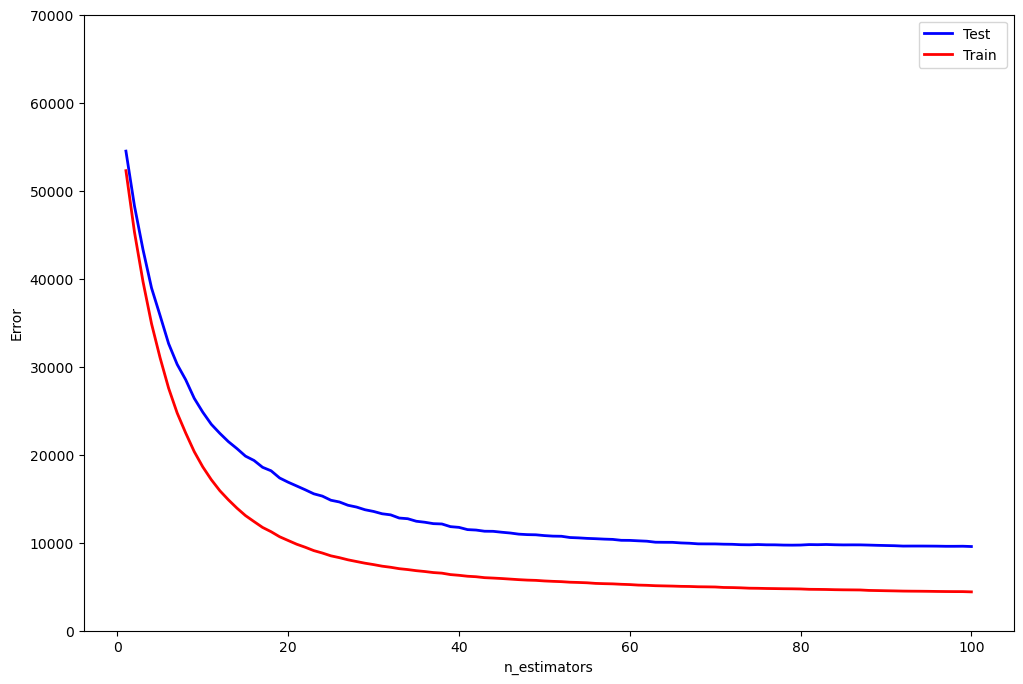

In [44]:
def deviance_plot(est, X_test, y_test, ax = None, label = '', train_color='red', test_color = 'blue', alpha= 1.0, ylim = (0,70000)):

    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        # test_dev[i] = est.loss_(y_test, pred)
        test_dev[i] = mean_squared_error(y_test, pred)
        # test_dev[i] = est.train_score_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (12,8))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color= test_color, label = 'Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label= 'Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(gbr, X_test, y_test)
ax.legend(loc='upper right')

In [45]:
def deviance_plot(est, X_test, y_test, ax = None, label = '', train_color='red', test_color = 'green', alpha= 1.0, ylim = (0,60000)):

    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (18,6))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color= test_color, label = 'Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label= 'Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    return test_dev, ax

def get_daily_values(X_test, y_test, gbr, full):
    p = X_test.copy()
    p['load'] = y_test
    p['times'] = full[full.timestamp >= pd.to_datetime('2014')]['timestamp']
    p['prediction'] = gbr.predict(X_test)
    p['error'] = np.abs(p['load'] - p['prediction'])
    p = p.set_index(p.times)
    daily_values = p.groupby(pd.TimeGrouper(freq='D')).aggregate(np.max)
    return daily_values

def plot_model_performance(X_test, y_test, gbr, full):
    daily_values = get_daily_values(X_test, y_test, gbr, full)
    times = daily_values.index
    fig, ax1 = plt.subplots(figsize=(18, 6),)
    ax1.plot(times, daily_values['load'], alpha=.5, color='blue', label='actual load' )
    ax1.plot(times, daily_values['prediction'], alpha=.5, color='red', label="Dan's predicted load, %.3f" %gbr.score(X_test, y_test))
    ax1.plot(times, daily_values['error'], alpha=.5, color = 'green', label='error')
    ax1.legend(loc='best')
    ax2 = ax1.twinx()
    ax2.plot(times, daily_values['temperaturef'], alpha = .5, color = 'orange', label='temperature')
#     ax2.plot(times, daily_values['discomfort_index'], alpha = .5, color = 'brown', label='discomfort_index')

#     ax2.plot(times, daily_values['dewpointf'], alpha = .5, color = 'yellow', label='dew point')
#     ax2.plot(times, daily_values['precipitationin'], alpha = .5, color = 'brown', label='precip')
    ax2.legend(loc='lower right')
    return ax1, ax2

def plot_days(gbr, full, day1, day2, weather=False):
    test_day = full[full.timestamp >= pd.to_datetime(day1)]
    test_day = test_day[test_day.timestamp < pd.to_datetime(day2)]
    predictions = gbr.predict(test_day[features])
    score = gbr.score(test_day[features], test_day['load'])    
    
    fig, ax = plt.subplots(figsize=(18, 6),)
    ax.plot(test_day.timestamp.values, test_day.load.values, label = 'Actual load', color = 'blue')
    ax.plot(test_day.timestamp.values, predictions, label = "Predicted load. R^2 = %.2f"%score, color= 'red')
    if weather == True:
        ax2 = ax.twinx()
        ax2.plot(test_day.timestamp.values, test_day.Temperature.values, label = 'temperature', color= 'orange')
    ax.legend(loc='best')
    ax.set_title(day1 + ' - '+ day2 + ' \n NYISO Capital Region ')
    ax.set_xlabel('time')
    ax.set_ylabel('load (megawatts)')
    return ax

<Axes: title={'center': '2020-02-01 - 2020-02-02 \n NYISO Capital Region '}, xlabel='time', ylabel='load (megawatts)'>

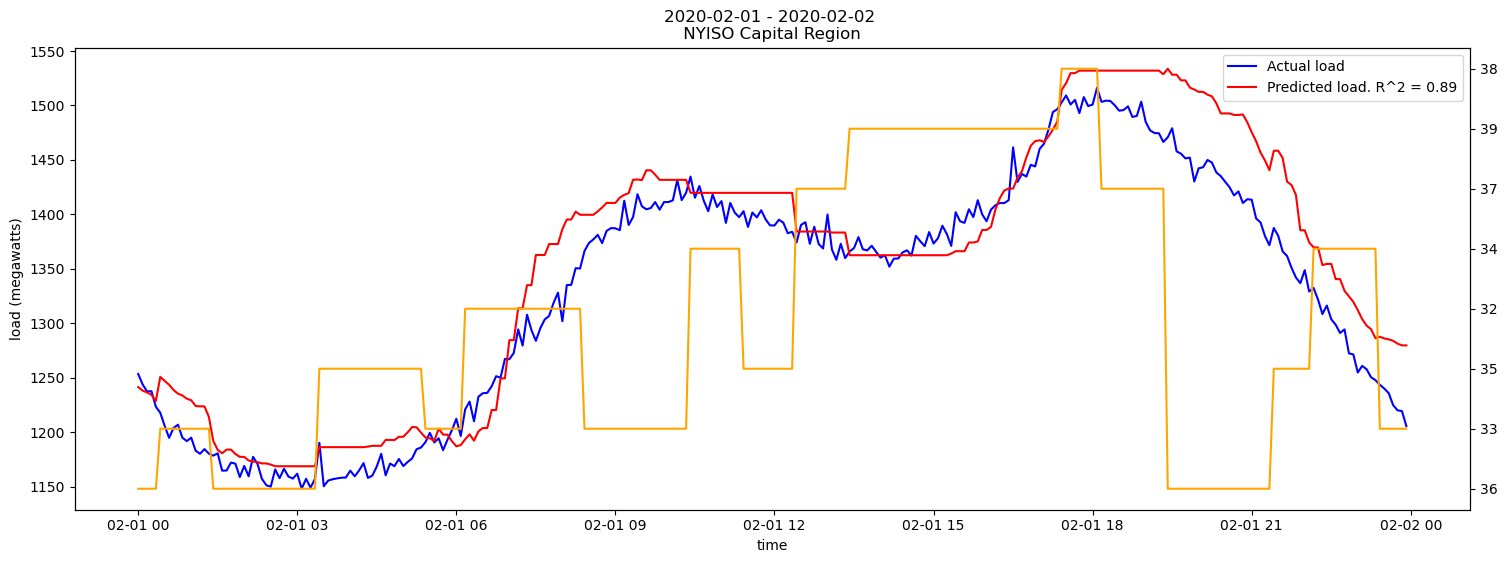

In [37]:
plot_days(gbr, full, '2020-02-01', '2020-02-02', True)

<Axes: title={'center': '2020-07-31 - 2020-08-02 \n NYISO Capital Region '}, xlabel='time', ylabel='load (megawatts)'>

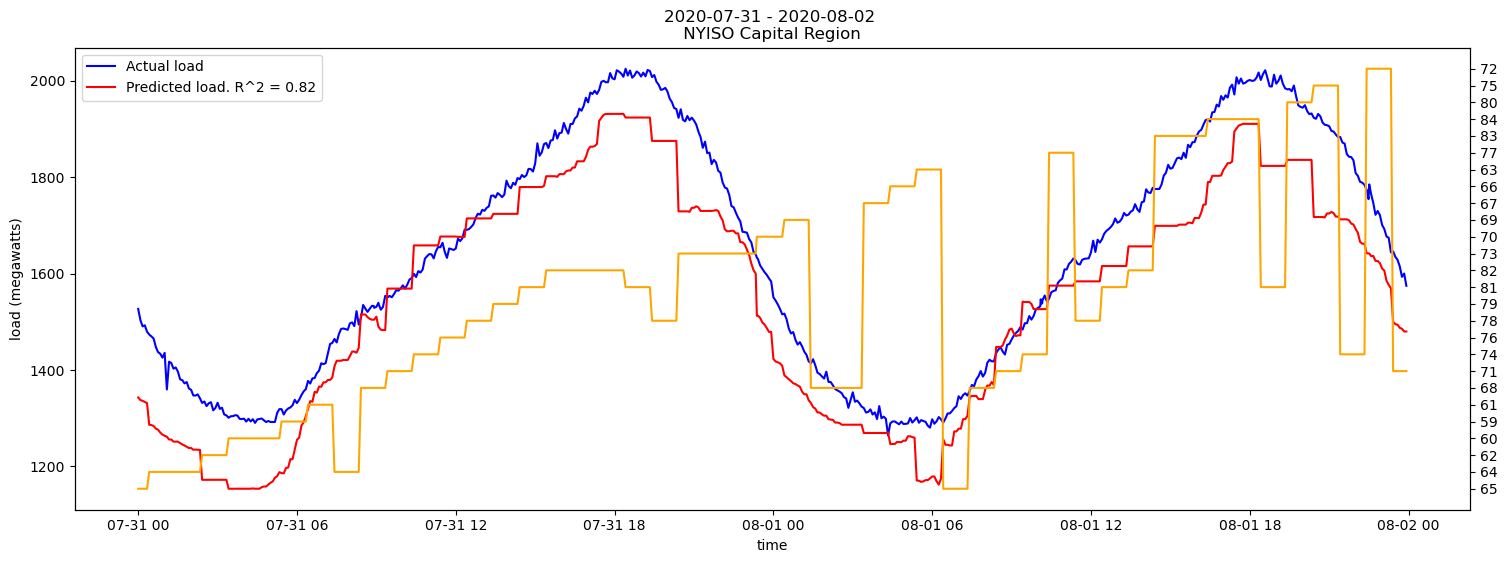

In [38]:
plot_days(gbr, full, '2020-07-31', '2020-08-02',True)

<Axes: title={'center': '2020-01-01 - 2020-01-07 \n NYISO Capital Region '}, xlabel='time', ylabel='load (megawatts)'>

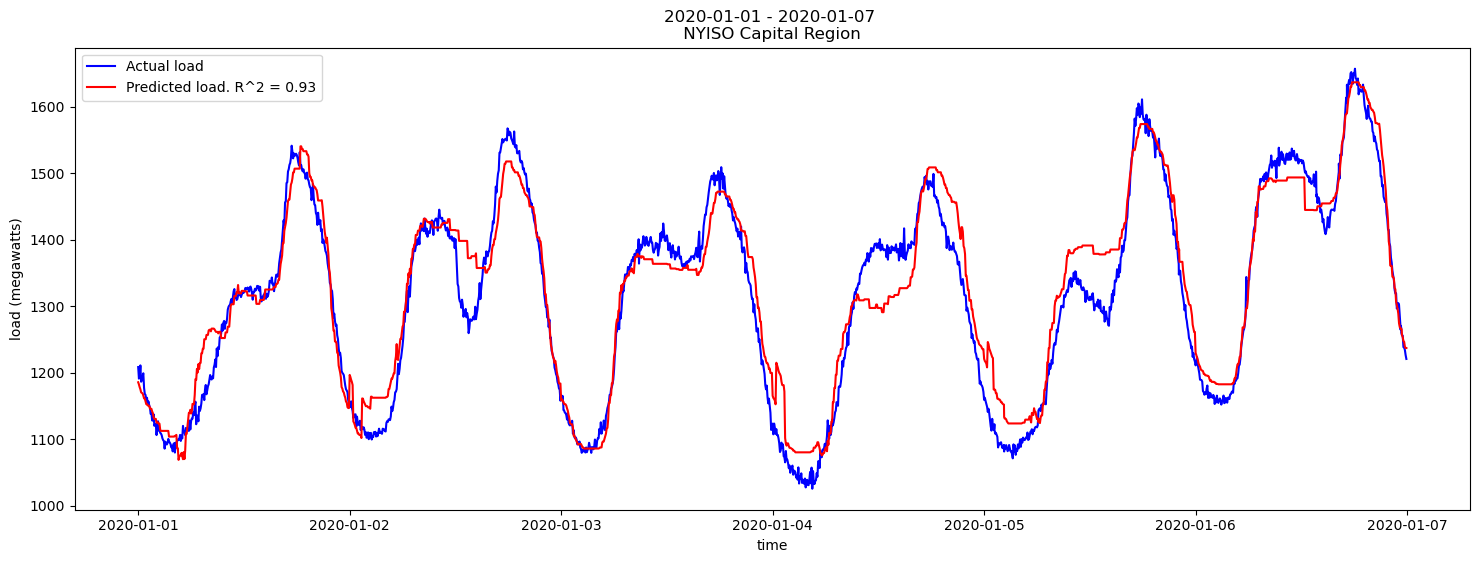

In [39]:
plot_days(gbr, full, '2020-01-01', '2020-01-07')

<Axes: title={'center': '2020-01-01 - 2020-12-31 \n NYISO Capital Region '}, xlabel='time', ylabel='load (megawatts)'>

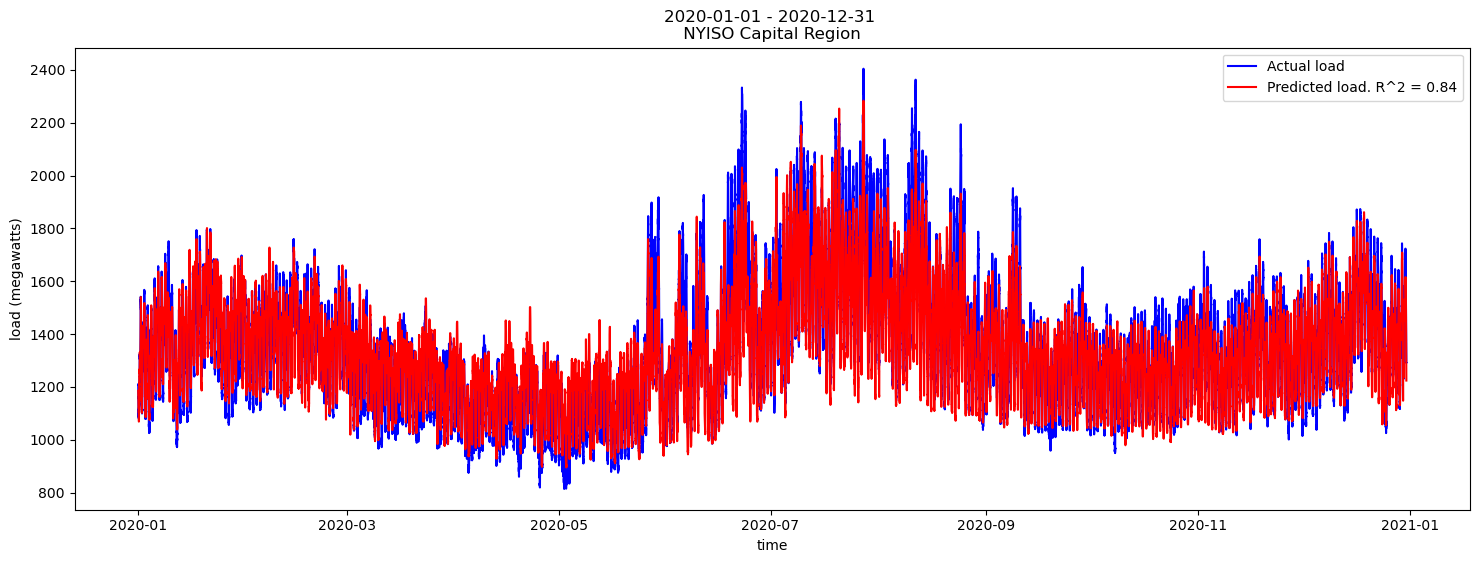

In [23]:
plot_days(gbr, full, '2020-01-01', '2020-12-31')

In [24]:
capital_forecast = pd.read_csv('capital_forecast_2020.csv')
capital_forecast['timestamp'] = capital_forecast.timestamp.apply(lambda x: pd.to_datetime(x))

In [25]:
capital_forecast

,timestamp,zone,forcast,gmt
0,2020-01-01 00:00:00,CAPITL,1160,5
1,2020-01-01 01:00:00,CAPITL,1118,6
2,2020-01-01 02:00:00,CAPITL,1086,7
3,2020-01-01 03:00:00,CAPITL,1073,8
4,2020-01-01 04:00:00,CAPITL,1072,9
...,...,...,...,...
8779,2020-12-31 19:00:00,CAPITL,1462,0
8780,2020-12-31 20:00:00,CAPITL,1407,1
8781,2020-12-31 21:00:00,CAPITL,1356,2
8782,2020-12-31 22:00:00,CAPITL,1311,3


In [26]:
subset_2020 = full[full.timestamp > pd.to_datetime('2020')]

In [27]:
subset_2020 = subset_2020[subset_2020.minute % 60 == 0]
with_forecast = pd.merge(subset_2020, capital_forecast, on='timestamp')
# with_forecast.drop('Unnamed: 0', axis=1, inplace=True)
with_forecast = with_forecast.rename(columns={'forcast': 'forecast'})
with_forecast['nyiso_mape'] = np.abs(with_forecast['load'] - with_forecast['forecast'])/with_forecast['load']


In [32]:
def compare_models(with_forecast, gbr, day1, day2, weather=False):
    test_day = with_forecast[with_forecast.timestamp >= pd.to_datetime(day1)]
    test_day = test_day[test_day.timestamp < pd.to_datetime(day2)]
    predictions = gbr.predict(test_day[features])
    
    end_day = (pd.to_datetime(day2) - pd.Timedelta('1 day')).strftime('%Y-%m-%d')
    
    mape = np.mean(np.abs(predictions - test_day['load'])/test_day['load'])
    score = gbr.score(test_day[features], test_day['load'])
    nyiso_mape = np.mean(test_day['nyiso_mape'])
#     nyiso_score = gbr.score(test_day[features], test_day['forecast'])
#     print(test_day['forecast'].shape)
#     nyiso_score = gbr.score(test_day['forecast'].reshape(-1, 1), test_day['load'])
    nyiso_score = ((test_day['load'] - test_day['forecast'])** 2).sum() / (((test_day['load'] - test_day['load'].mean()) ** 2).sum())
    nyiso_score = 1 - nyiso_score
    
    fig, ax = plt.subplots(figsize=(18, 8),)
    
    ax.plot(test_day.timestamp.values, test_day.load.values, label = 'actual load', color = 'blue', linewidth=3)
    
    ax.plot(test_day.timestamp.values, predictions, ls= 'dashed', lw=2,\
            label = "Predicted load, R^2 = {0:.3f}, MAPE = {1:.3f}".format(score,mape), color= 'red')
    
    ax.plot(test_day.timestamp.values, test_day.forecast.values, ls='dashed', lw=2,\
            label = 'NYISO forecast, R^2 = {0:.3f}, MAPE = {1:.3f}'.format(nyiso_score, nyiso_mape), color = 'green')
    
    if weather == True:
        ax2 = ax.twinx()
        ax2.plot(test_day.timestamp.values, test_day.temperaturef.values, label = 'temperature', color= 'orange')
#     ax.legend(loc='best')
#     ax.set_title(day1 + ' - '+ end_day + ' \n NYISO Capital Region ', fontsize=20)
    ax.legend(loc='best')
    ax.set_xlabel('time', fontsize=16)
    ax.set_ylabel('load (megawatts)', fontsize=16)
    ax.set_ylim(500,2500)
    return ax

<Axes: xlabel='time', ylabel='load (megawatts)'>

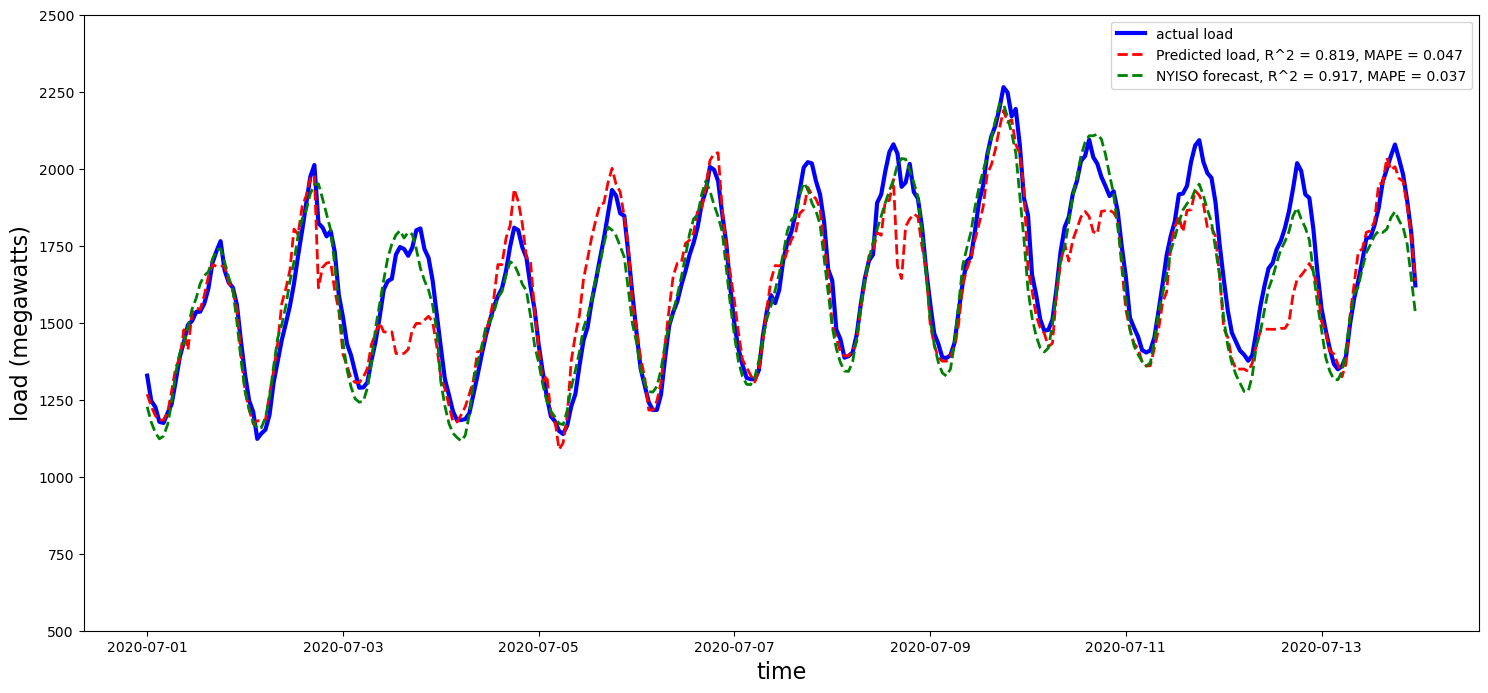

In [58]:
compare_models(with_forecast, gbr, '2020-07-01', '2020-07-14', weather=False)

<Axes: xlabel='time', ylabel='load (megawatts)'>

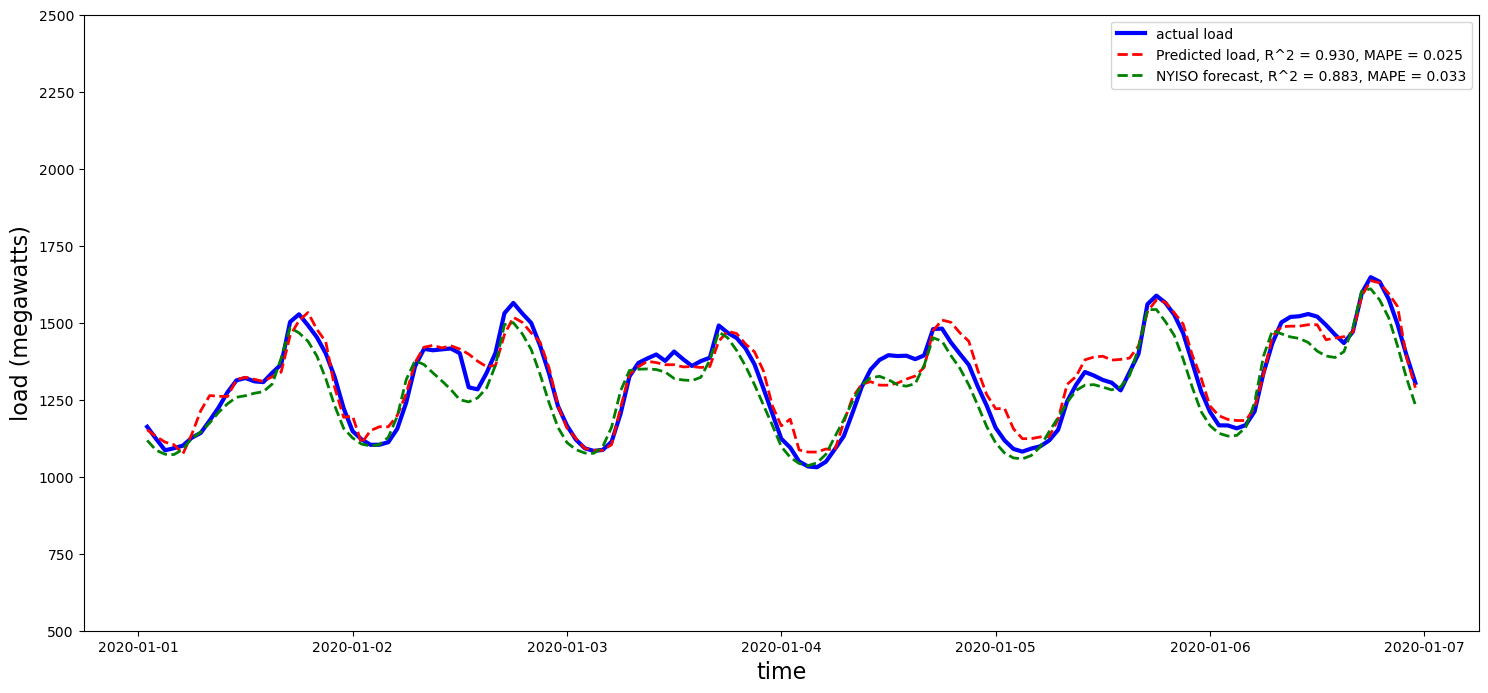

In [34]:
compare_models(with_forecast, gbr, '2020-01-01', '2020-01-07')

<Axes: xlabel='time', ylabel='load (megawatts)'>

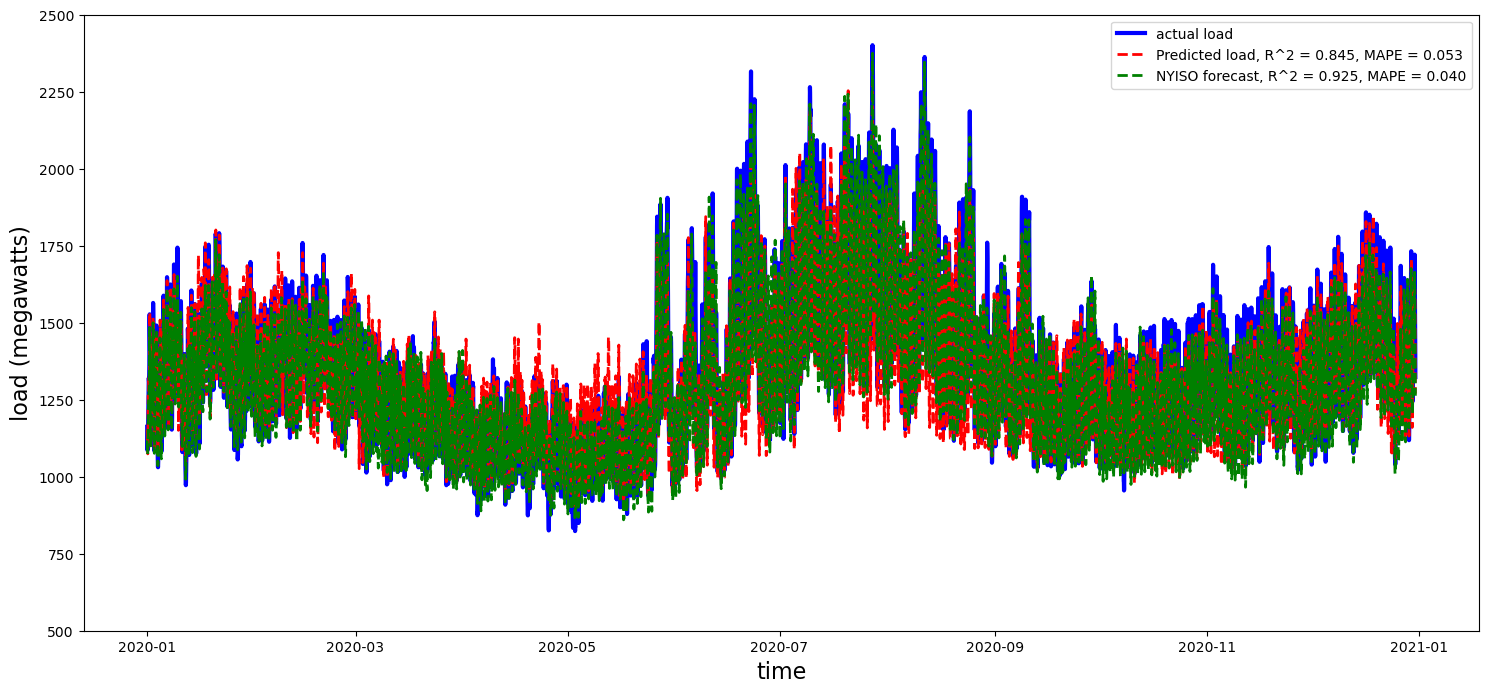

In [35]:
compare_models(with_forecast, gbr, '2020-01-01','2020-12-31')